In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t, f, norm

from sklearn.linear_model import LinearRegression

In [47]:
n = 50
sample = np.zeros((n, 6))
for i in range(n):
    ksi = np.random.uniform(-1, 1, 5)
    eta = np.random.normal(2+3*ksi[0]-2*ksi[1]+ksi[2]+ksi[3]-ksi[4], 1.5)
    sample[i][:5] = ksi
    sample[i][-1] = eta

## а

In [48]:
sample_df = pd.DataFrame(sample, columns = [0, 1, 2, 3, 4, 'eta'])
columns = list(sample_df.columns)
columns.remove('eta')

In [49]:
for i in columns:
    y_true =  sample_df.loc[ : ,i].copy()
    y_train = sample_df.drop([i, 'eta'], axis = 1).copy()
    
    lr = LinearRegression()
    lr.fit(y_train, y_true)
    y_pred = lr.predict(y_train)
    
    TSS =  np.sum((y_true - np.mean(y_true))**2)
    err = y_true - y_pred
    RSS = err.T@err
    
    R2 = (TSS - RSS)/ TSS
    if R2 >= 0.7:
        sample_df = sample_df.drop([i], axis = 1)

## b

In [50]:
sample_df['c'] = 1
sample_df = sample_df[['c', 0, 1, 2, 3, 4, 'eta']]

In [51]:
eta_true = sample_df.loc[ : ,'eta'].copy()
    
eta_train = np.ones((n,1))
eta_train = np.hstack([eta_train, np.array(sample_df[[0,1,2,3,4]])])

F = eta_train.T @ eta_train
F_inv = np.linalg.inv(F)

coef = F_inv @ eta_train.T @ eta_true

eta_pred = eta_train @ coef
eta_err = eta_true - eta_pred
RSS_eta = eta_err.T @ eta_err
TSS_eta = np.sum((eta_true - np.mean(eta_true))**2)

deltas = [coef[i] * (n - len(coef))**0.5/(RSS_eta*F_inv[i][i])**0.5 for i in range(len(coef))]

print(f'b0 = {coef[0]} \nbi = {coef[1:]}\nRSS = {np.round(RSS,5)}')

b0 = 1.9529675568991172 
bi = [ 2.51050387 -2.30573623  0.74730195  0.28484131 -0.89984784]
RSS = 16.55748


In [52]:
p_value_b = [abs(2*(1 - t.cdf(abs(d),n - len(coef)))) for d in deltas]
print(f'p_values = {np.round(p_value_b, 5)} => все коэффиценты значимы')

p_values = [0.      0.      0.      0.03129 0.38241 0.00462] => все коэффиценты значимы


## с

In [53]:
R2_eta = (TSS_eta - RSS_eta)/TSS_eta
print(f'коэффициент детерминации {np.round(R2_eta,4)}')

коэффициент детерминации 0.8109


In [54]:
delta_R2 = R2_eta**2 / (1-R2_eta**2) * (n - len(coef))/(len(coef)-1) 
p_value_R2 = abs((1 - f.cdf(abs(delta_R2),len(coef) -1 , n - len(coef)))) 
print(f'p_value = {np.round(p_value_R2,9)} => отвергаем теорию о незначимости регрессии')

p_value = 3e-09 => отвергаем теорию о незначимости регрессии


## d

In [55]:
x_test = np.zeros_like(coef)
x_test[0] = 1
y_pred = x_test @ coef
print(f'Значение в xk = 0: {np.round(y_pred,4)}')

Значение в xk = 0: 1.953


In [56]:
eps = 10e-6
proc_val = 0
for i in list(np.linspace(2, 10, 10**7)):
    if abs(t.cdf(i, n -len(coef)) - 0.975)<eps:
        proc_val = i
        break

tmp = (n - len(coef))**0.5/(RSS_eta*(1+x_test@F_inv@x_test.T))**0.5
left = y_pred - proc_val/tmp
right = y_pred + proc_val/tmp

In [57]:
print(f'Доверительный интервал: ({np.round(left, 4)}; {np.round(right, 4)})')

Доверительный интервал: (-0.5459; 4.4518)


## e

In [58]:
I = np.sum(np.sum(eta_err[i]<eta_err[:i]) for i in range(len(eta_err)))
delta_I = (I - n*(n-1)/4)/((n**3)/36)**0.5
p_val_I = 2*(1 - norm.cdf(delta_I))
print(f'p_value = {np.round(p_val_I,4)} => нет оснований отвергнуть гипотезу о независимости ошибок')

p_value = 0.2186 => нет оснований отвергнуть гипотезу о независимости ошибок


C:\Users\Arina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


## f

In [59]:
var_est = np.var(eta_err)
mean_est = np.mean(eta_err)

n_dots = 100
points = np.linspace(np.min(eta_err), np.max(eta_err), n_dots)

F_emp = [np.sum(eta_err<el)/n for el in np.sort(eta_err)]
F_acc = [norm.cdf(i, mean_est, var_est) for i in np.sort(eta_err)]

delta_acc = n**0.5*max(list(map(lambda x,y: abs(x-y), F_acc, F_emp)))

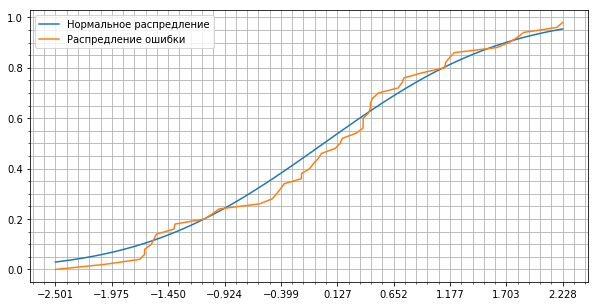

In [60]:
plt.figure(figsize = (10, 5))
plt.plot(points, norm.cdf(points, mean_est, var_est), label = "Нормальное распредление")
plt.plot(np.sort(eta_err), F_emp, label = "Распредление ошибки")
plt.xticks(np.linspace(min(eta_err), max(eta_err), 10))
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor')
plt.legend()

In [61]:
N = 50000

deltas_kolm = []
for i in range(N):
    sample = np.random.normal(mean_est, var_est, n)
    points = np.linspace(0, max(sample), 100)
    f1 = [np.sum(sample<elem)/n for elem in points]
    f2 = [np.sum(eta_err<elem)/n for elem in points]
    tmp = n**0.5*max(list(map(lambda x,y: abs(x-y), f1, f2)))
    deltas_kolm.append(tmp)
    
deltas_var = np.sort(deltas_kolm)
k = len(deltas_var[deltas_var<delta_acc])
p_value = 1-((k-1)/N)
print(f"p_value = {round(p_value, 2)} => нет оснований отвергать H0")

p_value = 0.97 => нет оснований отвергать H0


## g

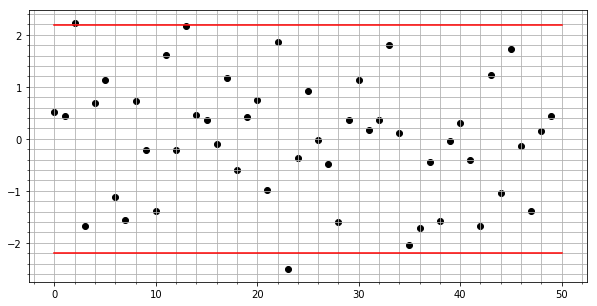

In [62]:
sigma_out = np.median(abs(eta_err))/0.675

plt.figure(figsize = (10, 5))
plt.scatter(np.arange(n), eta_err, color = 'k')
plt.plot([0, 50], [-2*sigma_out, -2*sigma_out], color = 'r')
plt.plot([0, 50], [2*sigma_out, 2*sigma_out], color = 'r')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor')

In [63]:
eta_true_no_out = eta_err[(eta_err<2*sigma_out) & (eta_err>-2*sigma_out)]
to_drop = list(np.setdiff1d(eta_true.index, eta_true_no_out.index))
print(f'Новое количество факторов = {len(eta_true_no_out)}')

Новое количество факторов = 48


In [64]:
sample_df_no_out = sample_df.drop(to_drop, axis=0)

In [65]:
n_eta_true = sample_df_no_out.loc[ : ,'eta'].copy()
    
n_eta_train = np.ones((len(sample_df_no_out),1))
n_eta_train = np.hstack([n_eta_train, np.array(sample_df_no_out[[0,1,2,3,4]])])

n_F = n_eta_train.T @ n_eta_train
n_F_inv = np.linalg.inv(n_F)

n_coef = F_inv @ n_eta_train.T @ n_eta_true

n_eta_pred = n_eta_train @ n_coef
n_eta_err = n_eta_true - n_eta_pred
n_RSS_eta = n_eta_err.T @ n_eta_err
n_TSS_eta = np.sum((n_eta_true - np.mean(n_eta_true))**2)

n_R2_eta = (n_TSS_eta - n_RSS_eta)/n_TSS_eta
print(f'R2 с выбросамии: {np.round(R2_eta, 5)}\nR2 после удаления выбросов: {np.round(n_R2_eta, 5)}') 

R2 с выбросамии: 0.81091
R2 после удаления выбросов: 0.8365


## h

In [66]:
cv = []

for i in range(len(sample_df)):
    x_train = sample_df.drop(i, axis = 0)
    x_train = x_train.drop('eta', axis = 1)
    
    y_train = sample_df.drop(i, axis = 0)
    y_train = y_train['eta']
    
    x_test = np.hstack(sample_df.iloc[i].drop('eta'))
    y_test = sample_df.iloc[i]['eta']
    
    F = x_train.T @ x_train
    F_inv = np.linalg.inv(F)

    coef = F_inv @ x_train.T @ y_train

    y_pred = x_test @ coef
    err = y_test - y_pred
    
    cv.append(err**2)
    
R_cv = 1 - np.sum(cv)/TSS_eta
print(f'R2cv = {np.round(R_cv,4)}')

R2cv = 0.7538


## i

In [67]:
ksi_5 = np.random.uniform(-1,1,5)
eta_5 = np.random.normal(2+3*ksi_5[0]-2*ksi_5[1]+ksi_5[2]+ksi_5[3]-ksi_5[4], 1.5, 5)
sigma_5 = (1/4)*np.sum((eta_5 - np.mean(eta_5))**2)
delta_5 = RSS_eta/((n - len(coef))*sigma_5)
p_value_5 = 1 - f.cdf(delta_5,  n - len(coef), 4)
print(f'p_value = {np.round(p_value_5,5)} => нет оснований отвергнуть гипотезу о равенстве дисперсий')

p_value = 0.87317 => нет оснований отвергнуть гипотезу о равенстве дисперсий


## j

In [68]:
to_del = np.argmax(p_value_b)
less_sample = sample_df.drop(to_del, axis = 1)

In [75]:
less_y_train = less_sample.loc[ : ,'eta'].copy()
    
cols = list(less_sample.columns)
cols.remove('eta')
            
less_x_train = np.array(sample_df[cols])

less_F = less_x_train.T @ less_x_train
less_F_inv = np.linalg.inv(less_F)

less_coef = less_F_inv @ less_x_train.T @ less_y_train
less_eta_pred = less_x_train @ less_coef

less_eta_err = less_y_train - less_eta_pred
less_RSS_eta = less_eta_err.T @ less_eta_err
less_TSS_eta = np.sum((less_y_train - np.mean(less_y_train))**2)

less_deltas = [less_coef[i] * (n - len(less_coef))**0.5/(less_RSS_eta*less_F_inv[i][i])**0.5 for i in range(len(less_coef))]
less_p_value_b = [abs(2*(1 - t.cdf(abs(d),n - len(less_coef)))) for d in less_deltas]

print(f'p_values = {np.round(less_p_value_b, 5)} => отвергаем теорию о незначимости коэффициентов (кроме последнего случая)')

p_values = [0.      0.      0.      0.04305 0.54994] => отвергаем теорию о незначимости коэффициентов (кроме последнего случая)


In [72]:
less_R2_eta = (less_TSS_eta - less_RSS_eta)/less_TSS_eta
print(f'Коэффициент детерминации {np.round(less_R2_eta,4)}')

less_delta_R2 = less_R2_eta**2 / (1-less_R2_eta**2) * (n - len(less_coef))/(len(less_coef)-1) 
less_p_value_R2 = abs((1 - f.cdf(abs(less_delta_R2),len(less_coef) -1 , n - len(less_coef)))) 
print(f'p_value = {np.round(less_p_value_R2,9)} => отвергаем теорию о незначимости регрессии')

Коэффициент детерминации 0.7726
p_value = 1.9e-08 => отвергаем теорию о незначимости регрессии


In [74]:
comp = pd.DataFrame(columns = ['R2', 'b0', 'b1', 'b2', 'b3', 'b4', 'b5' ])
comp.loc['first regression'] = [R2_eta,*coef]
tmp = list(less_coef.copy())
tmp.insert(to_del, 0)
comp.loc['second regression'] = [less_R2_eta, *tmp]
comp

,R2,b0,b1,b2,b3,b4,b5
first regression,0.810911,1.941302,2.529329,-2.316466,0.758755,0.30589,-0.901240
second regression,0.772633,1.906360,2.658879,-2.499956,0.758381,0.00000,0.210235


## k

In [76]:
delta_boot = (less_RSS_eta - RSS_eta) / RSS_eta * (n - len(less_coef))/(len(less_coef) - len(coef))

In [77]:
n_boot = 1000
deltas_boot = []
for i in range(n_boot):
    h1_sample = sample_df.loc[np.random.randint(0,len(sample_df),len(sample_df))]
    h0_sample = h1_sample.drop(to_del, axis = 1)
    
    h1_x = h1_sample.drop('eta', axis = 1)
    h0_x = h0_sample.drop('eta', axis = 1)
    
    h1_y = h1_sample['eta']
    h0_y = h0_sample['eta']
    
    h1_F = h1_x.T @ h1_x 
    h0_F = h0_x.T @ h0_x
   
    h1_F_inv = np.linalg.inv(h1_F) 
    h0_F_inv = np.linalg.inv(h0_F)
   
    h1_coef = h1_F_inv @ h1_x.T @ h1_y
    h0_coef = h0_F_inv @ h0_x.T @ h0_y
    
    h1_pred = h1_x @ np.ravel(h1_coef)
    h0_pred = h0_x @ np.ravel(h0_coef)
    
    h1_err = h1_y - h1_pred
    h0_err = h0_y - h0_pred
    
    h1_RSS = h1_err.T @ h1_err
    h0_RSS = h0_err.T @ h0_err

    tmp = (h1_RSS - h0_RSS) / h0_RSS * (n - len(h1_coef))/(len(h1_coef) - len(h0_coef))
    deltas_boot.append(tmp)

In [78]:
deltas_boot_var = np.sort(deltas_boot)
k = len(deltas_boot_var[deltas_boot_var<delta_boot])
p_value = 1-((k-1)/n_boot)
print(f"p_value = {round(p_value, 2)} => нет оснований отвергать H0")

p_value = 0.64 => нет оснований отвергать H0
